In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

from torchvision.datasets.utils import download_file_from_google_drive
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from torch import Tensor

import os

from skimage import data
from skimage.color import rgb2gray

from torchvision.datasets.folder import default_loader


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
def make_dataset_train(root: str) -> list:
    """Reads a directory with data.
    """
    dataset = []

    # Dir names
    lr_dir = '5_low/train/'
    hr_dir = '5_high/train/'   
    
    # Get all the filenames from lr
    lr_fnames = sorted(os.listdir(os.path.join(root, lr_dir)))

    hr_fnames = sorted(os.listdir(os.path.join(root, hr_dir)))
    i = 1

    # Compare file names
    for hr_fname in hr_fnames:

            if i>=1000:
              break

            if hr_fname in lr_fnames:
                # create pair of full path to the corresponding images
                lr_path = os.path.join(root, lr_dir, hr_fname)
                hr_path = os.path.join(root, hr_dir, hr_fname)

                item = (lr_path, hr_path)
                # append to the list dataset
                dataset.append(item)
                i = i+1
            else:
                continue

    return dataset

In [5]:
def make_dataset_test(root: str) -> list:
    """Reads a directory with data.
    """
    dataset = []

    # Dir names
    lr_dir = '7_low/train/'
    hr_dir = '7_high/train/' 
    
    # Get all the filenames from lr
    lr_fnames = sorted(os.listdir(os.path.join(root, lr_dir)))
    
    i = 1

    # Compare file names:
    for hr_fname in sorted(os.listdir(os.path.join(root, hr_dir))):
      
            if i>=300:
                break

            if hr_fname in lr_fnames:
                # create pair of full path to the corresponding images
                lr_path = os.path.join(root, lr_dir, hr_fname)
                hr_path = os.path.join(root, hr_dir, hr_fname)

                item = (lr_path, hr_path)
                # append to the list dataset
                dataset.append(item)
                i = i+1

            else:
                continue

    return dataset

In [6]:
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
from torchvision.datasets.folder import pil_loader


class CustomDatasetTrain(Dataset):
  def __init__(self,
               root = 'gdrive/My Drive',
               loader=pil_loader,
               transform=None,
               transofrmlow = None):


      self.root = root
      self.target_transform = transform
      self.target_transformlow = transofrmlow

      # Prepare dataset
      samples = make_dataset_train(self.root)
      
      self.loader = loader
      self.samples = samples
      # list of lr
      self.lr_samples = [s[1] for s in samples]
      # list of hr
      self.hr_samples = [s[1] for s in samples]


  def __getitem__(self, index):
      """Returns a data sample from  dataset.
      """
      # getting our paths to images
      lr_path, hr_path = self.samples[index]
        
      # import each image using loader
      lr_sample = self.loader(lr_path)
      hr_sample = self.loader(hr_path)
        
      # tranforms

      lr_sample = self.target_transformlow(lr_sample)
      hr_sample = self.target_transform(hr_sample)      


      return lr_sample, hr_sample

  def __len__(self):
      return len(self.samples)

In [7]:
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader


class CustomDatasetTest(Dataset):
  def __init__(self,
               root = 'gdrive/My Drive',
               loader=pil_loader,
               transform=None,
               transofrmlow = None):


      self.root = root
      self.target_transform = transform
      self.target_transformlow = transofrmlow

      # Prepare dataset
      samples = make_dataset_test(self.root)

      self.loader = loader
      self.samples = samples
      # list of lr
      self.lr_samples = [s[1] for s in samples]
      # list of hr
      self.hr_samples = [s[1] for s in samples]


  def __getitem__(self, index):
      """Returns a data sample from  dataset.
      """
      # getting paths to images
      lr_path, hr_path = self.samples[index]
        
      # import each image using loader
      lr_sample = self.loader(lr_path)
      hr_sample = self.loader(hr_path)
        
      # tranforms
      lr_sample = self.target_transformlow(lr_sample)
      hr_sample = self.target_transform(hr_sample)      

      return lr_sample, hr_sample

  def __len__(self):
      return len(self.samples)

In [8]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

def gaussian_blur(img):
    image = np.array(img)
    image_blur = cv2.GaussianBlur(image,(3,3),1)
    new_image = image_blur
    im = Image.fromarray(new_image)
    return im

im_tf = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((192,256)),                  
    transforms.ToTensor(),
    transforms.Normalize((0), (1))
])

sm_tf = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((96,128)),                  
    transforms.ToTensor(),
    transforms.Normalize((0), (1))
])

# create training and validation datasets

train_set = CustomDatasetTrain(transform=im_tf, transofrmlow = sm_tf)
valid_set = CustomDatasetTest(transform=im_tf, transofrmlow = sm_tf)

In [9]:
# create a data loader
train_loader = DataLoader(train_set, batch_size=5, shuffle=True)

# create a validation loader 
valid_loader = DataLoader(valid_set, batch_size=5, shuffle = False)

print(f'train samples: {len(train_loader)}')
print(f'test samples: {len(valid_loader)}')


train samples: 200
test samples: 60


In [10]:
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels):
        super(UpsampleBLock, self).__init__()
        up_scale = 2
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

class SalUNet(nn.Module):
    def __init__(self):
        super(SalUNet, self).__init__()

        # down-scale
        self.conv1_e1 = ConvAct(1, 128)
        self.conv1_e2 = ConvAct(128, 128)
        self.down1 = nn.MaxPool2d(2, 2)

        # down-scale
        self.conv2_e1 = ConvAct(128, 256)
        self.conv2_e2 = ConvAct(256, 256)
        self.down2 = nn.MaxPool2d(2, 2)
        
        # down-scale
        self.conv3_e1 = ConvAct(256, 512)
        self.conv3_e2 = ConvAct(512, 512)
        self.down3 = nn.MaxPool2d(2, 2)
        
        # down-scale
        self.conv4_e1 = ConvAct(512, 1024)
        self.conv4_e2 = ConvAct(1024, 1024)
        self.down4 = nn.MaxPool2d(2, 2)

        
        self.conv5_1 = ConvAct(1024, 2048)
        self.conv5_2 = ConvAct(2048, 2048)
        
        # up-scale
        self.up4 = nn.ConvTranspose2d(2048, 1024, 3, 2, 1, 1)
        self.conv4_d1 = ConvAct(2048, 1024)
        self.conv4_d2 = ConvAct(1024, 1024)

        # up-scale
        self.up3 = nn.ConvTranspose2d(1024, 512, 3, 2, 1, 1)
        self.conv3_d1 = ConvAct(1024, 512)
        self.conv3_d2 = ConvAct(512, 512)

        # up-scale
        self.up2 = nn.ConvTranspose2d(512, 256, 3, 2, 1, 1)
        self.conv2_d1 = ConvAct(512, 256)
        self.conv2_d2 = ConvAct(256, 256)

        # up-scale
        self.up1 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.conv1_d1 = ConvAct(256, 128)
        self.conv1_d2 = ConvAct(128, 128)

        self.upsample = UpsampleBLock(128)

        self.output_layer = ConvAct(128,1,1,1)   

  
    def forward(self, x):
        
        # level 1 - encode
        x = self.conv1_e1(x)
        x = out1 = self.conv1_e2(x)
        x = self.down1(x)

        # level 2 - encode
        x = self.conv2_e1(x)
        x = out2 = self.conv2_e2(x)
        x = self.down2(x)

        # level 3 - encode
        x = self.conv3_e1(x)
        x = out3 = self.conv3_e2(x)
        x = self.down3(x)

        # level 4 - encode
        x = self.conv4_e1(x)
        x = out4 = self.conv4_e2(x)
        x = self.down4(x)

        # level 5 - encode/decode
        x = self.conv5_1(x)
        x = self.conv5_2(x)

        # level 4 - decode
        x = self.up4(x)
        x = torch.cat((x, out4), dim=1)
        x = self.conv4_d1(x)
        x = self.conv4_d2(x)

        # level 3 - decode
        x = self.up3(x)
        x = torch.cat((x, out3), dim=1)
        x = self.conv3_d1(x)
        x = self.conv3_d2(x)

        # level 2 - decode
        x = self.up2(x)
        x = torch.cat((x, out2), dim=1)
        x = self.conv2_d1(x)
        x = self.conv2_d2(x)

        # level 1 - decode
        x = self.up1(x)
        x = torch.cat((x,out1),dim=1)
        x = self.conv1_d1(x)
        x = self.conv1_d2(x)

        x = self.upsample(x)
        
        # make predictions
        x = self.output_layer(x)

        return x

    

_named_activations = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'prelu': nn.PReLU,
    'leakyrelu': nn.LeakyReLU,
    'elu': nn.ELU
}

def same_padding(kernel, dilation):
    return int((kernel + (kernel - 1) * (dilation - 1) - 1) / 2)


def get_activation_by_name(name, **kwargs):
    return _named_activations[name](**kwargs)


class ConvAct(nn.Module):
    """Conv->Activation"""
    def __init__(
            self, in_channels, out_channels,
            kernel=3, dilation=1, activation='relu'):
        super(ConvAct, self).__init__()
        padding = same_padding(kernel, dilation)
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel,
            padding=padding,
            dilation=dilation)
        self.activation = get_activation_by_name(activation)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv.reset_parameters()
        nn.init.xavier_uniform_(self.conv.weight)

    def forward(self, x):
        return self.activation(self.conv(x))

In [11]:
# instantiate model and move it to the GPU
device = 'cuda'
model = SalUNet()
model.to(device);

In [12]:
# save checkpoints to the checkpoints folder. Create it.
!mkdir -p checkpoints

In [13]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [14]:
# create the criterion to optimize (the loss function).
criterion = nn.L1Loss()
loss_forPSNR_cr = nn.MSELoss()

# create an SGD optimizer with learning rate 0.01, momentum 0.9, and nesterov momentum turned on
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)


In [15]:
import pytorch_ssim

valid_loss = []
test_loss = []

def train_for_epoch(loader, model, optimizer, criterion):
    n_steps = len(train_loader)    
    
    # put the model in train mode
    model.train()

    # iterate over batches
    for step, (batch, targets) in enumerate(loader):

        # Move the training data to the GPU
        batch = batch.to(device)
        targets = targets.to(device)

        # clear previous gradient computation
        optimizer.zero_grad()

        # forward propagation
        predictions = model(batch)

        # calculate the loss
        loss = criterion(predictions, targets)

        # backpropagate to compute gradients
        loss.backward()

        # update model weights
        optimizer.step()

        test_loss.append(loss.item())
        
        yield step, n_steps, float(loss)
        

def validate(loader, model, optimizer, criterion):
    
    # put the model in eval mode
    model.eval()
    avg_psnr = 0
    avg_ssim = 0
    
    # no_grad to save memory
    with torch.no_grad():
    
        for step, (batch, targets) in enumerate(loader):
            
            # Move the training batch to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # forward propagation
            predictions = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)
            
            #PSNR
            loss_PSNR = loss_forPSNR_cr(predictions, targets)
            psnr = 10 * log10(1 / loss_PSNR.item())
            avg_psnr += psnr

            #SSIM
            ssimVal = pytorch_ssim.ssim(predictions, targets)
            avg_ssim +=ssimVal

            # update running loss value
            valid_loss.append(loss.item())

    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(loader)))
    print("===> Avg. SSIM: {:.4f} dB".format(avg_ssim / len(loader)))
    
    return float(loss)
        

def monitor_progress(train_generator):
    start_time = time.time()
    for step, n_steps, loss in train_generator:
        elapsed = int(time.time() - start_time)
        print(f'\rBatch {step+1:03d}/{n_steps}  loss: {loss:0.4f}  elapsed: {elapsed}s',
              end='', flush=True)
    print()
    yield step, n_steps, loss
        
        
def run_train_generator(train_generator):
    for step, n_steps, loss in train_generator:
        pass
    return loss
           

In [16]:
def train(first_epoch, n_epochs):

    # keep track of losses
    train_losses, valid_losses = [], []

    for epoch in range(first_epoch, n_epochs + first_epoch):

        # train
        train_generator = train_for_epoch(train_loader, model, optimizer, criterion)
        train_generator = monitor_progress(train_generator)
        train_loss = run_train_generator(train_generator)
        train_losses.append(train_loss)
        print('Epoch {} train loss: {:.5f}'.format(epoch, train_loss))

        # validate
        valid_loss = validate(valid_loader, model, optimizer, criterion)
        valid_losses.append(valid_loss)
        print('Epoch {} validation loss: {:.5f}'.format(epoch, valid_loss))

        # Save a checkpoint
        checkpoint_filename = 'checkpoints/salunet-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
   
    return train_losses, valid_losses

In [17]:
train_losses, valid_losses = train(first_epoch=1, n_epochs=5)

Batch 200/200  loss: 0.0513  elapsed: 468s
Epoch 1 train loss: 0.05134
===> Avg. PSNR: 23.1500 dB
===> Avg. SSIM: 0.7568 dB
Epoch 1 validation loss: 0.04831
Batch 200/200  loss: 0.0426  elapsed: 73s
Epoch 2 train loss: 0.04259
===> Avg. PSNR: 24.3195 dB
===> Avg. SSIM: 0.8398 dB
Epoch 2 validation loss: 0.04372
Batch 200/200  loss: 0.0307  elapsed: 73s
Epoch 3 train loss: 0.03070
===> Avg. PSNR: 26.1698 dB
===> Avg. SSIM: 0.8759 dB
Epoch 3 validation loss: 0.03567
Batch 200/200  loss: 0.0357  elapsed: 73s
Epoch 4 train loss: 0.03566
===> Avg. PSNR: 26.8839 dB
===> Avg. SSIM: 0.8969 dB
Epoch 4 validation loss: 0.03247
Batch 200/200  loss: 0.0289  elapsed: 73s
Epoch 5 train loss: 0.02887
===> Avg. PSNR: 27.2647 dB
===> Avg. SSIM: 0.9079 dB
Epoch 5 validation loss: 0.03112


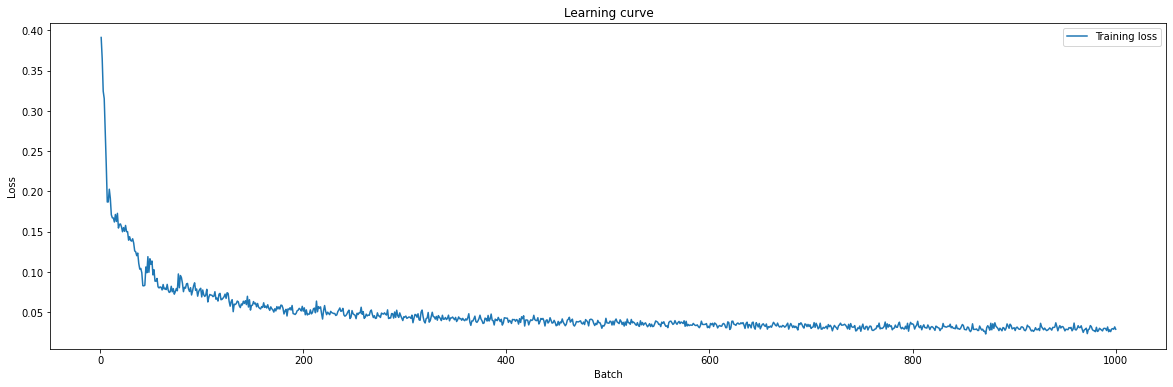

In [18]:
epochs = range(1, len(test_loss) + 1)

plt.figure(figsize=(20,6))
plt.plot(epochs, test_loss, label='Training loss')
plt.legend()
plt.title('Learning curve')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

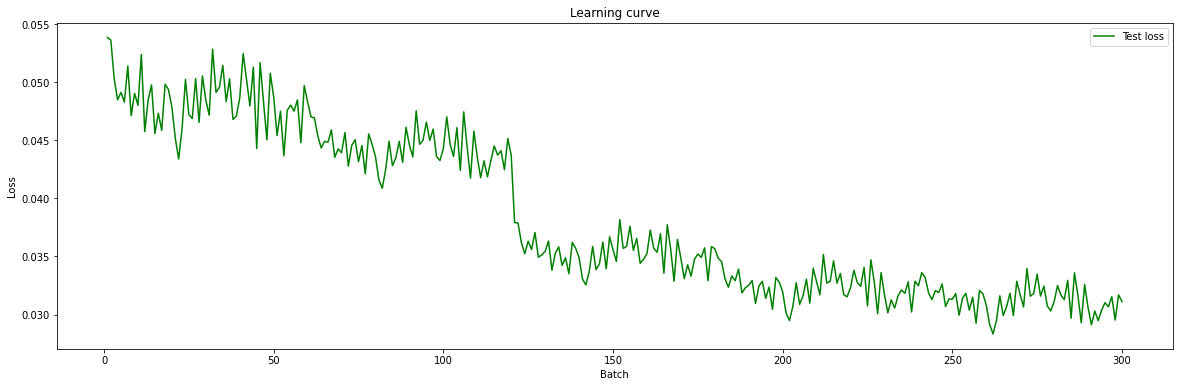

In [19]:
epochs = range(1, len(valid_loss) + 1)

plt.figure(figsize=(20,6))
plt.plot(epochs, valid_loss, label='Test loss', color = 'g')
plt.legend()
plt.title('Learning curve')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

In [20]:
def show_examples(dataset, model, count=5, size=(10.3, 9.5)):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # put model in eval mode
    model.eval()
    
    # create a colab grid
    grid = widgets.Grid(3, count)

    pix_mean = torch.as_tensor([0, 0, 0], dtype=torch.float32, device=device)
    pix_std = torch.as_tensor([1, 1, 1], dtype=torch.float32, device=device)
  
    
    with torch.no_grad():
        for i, (batch, targets) in enumerate(itertools.islice(loader, count)):
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            
            # unnormalize image
            image = batch[0].mul(pix_std[:, None, None]).add(pix_mean[:, None, None])

            targets = targets[0].mul(pix_std[:, None, None]).add(pix_mean[:, None, None])

            # convert to PIL images
            image = tF.to_pil_image(image.cpu())
            target = tF.to_pil_image(targets.cpu())
            #y_pred = tF.to_pil_image(predictions.cpu())

            data = predictions.cpu().detach().numpy()
            data = data.squeeze(0)
            data = data.squeeze(0)

            im = Image.fromarray(np.uint8(cm.gray(data)*255))
            
            # display
            with grid.output_to(0,i):
                grid.clear_cell()
                plt.figure(figsize=size)
                plt.title('LR')
                plt.imshow(image)
            with grid.output_to(1,i):
                grid.clear_cell()
                plt.figure(figsize=size)
                plt.title('HR')
                plt.imshow(target)
            with grid.output_to(2,i):
                grid.clear_cell()
                plt.figure(figsize=size)
                #plt.imshow(y_pred)
                plt.title('SR')
                plt.imshow(im) 

,,,,
,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

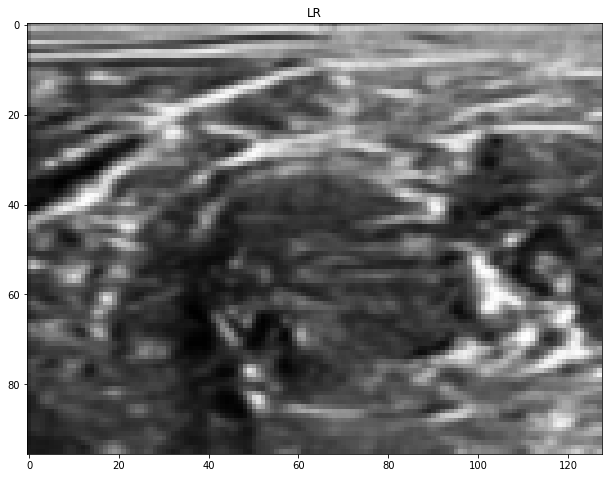

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

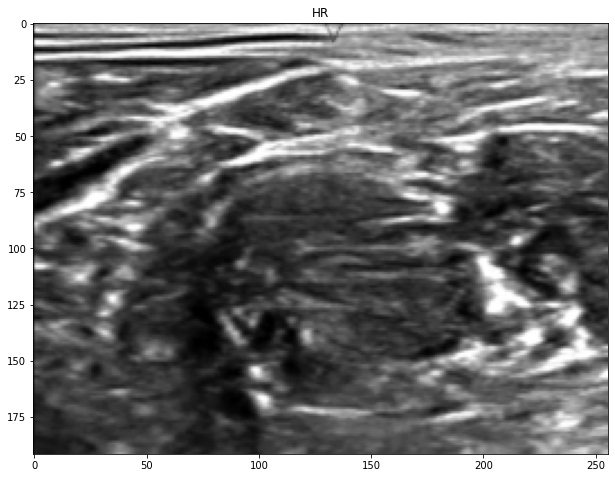

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

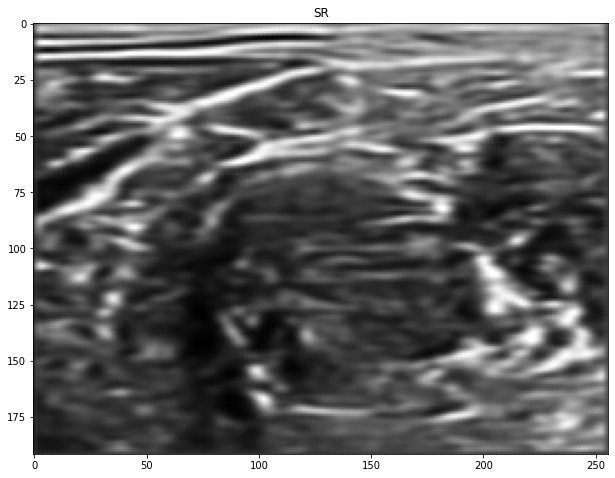

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

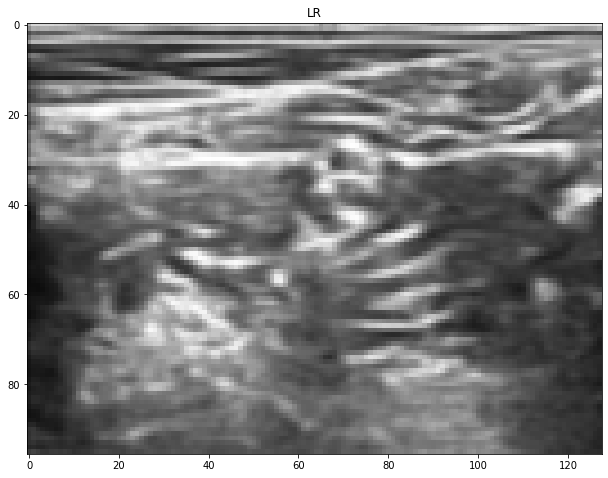

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

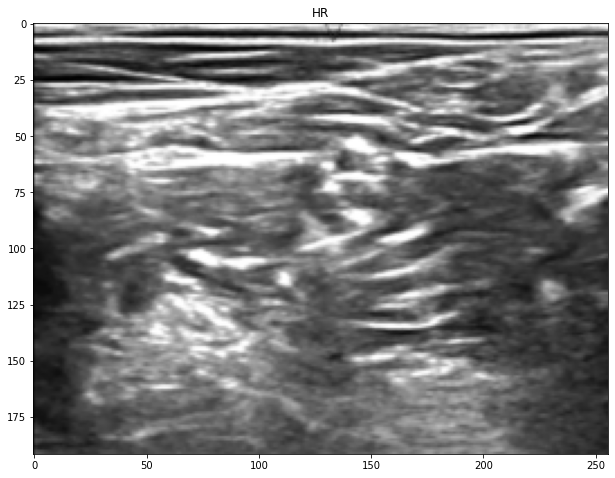

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

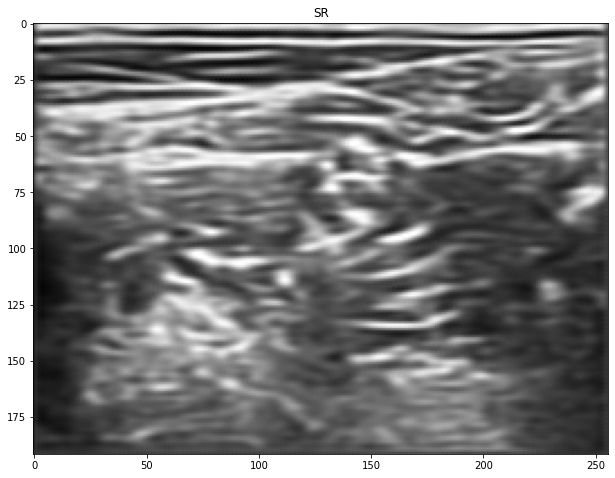

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

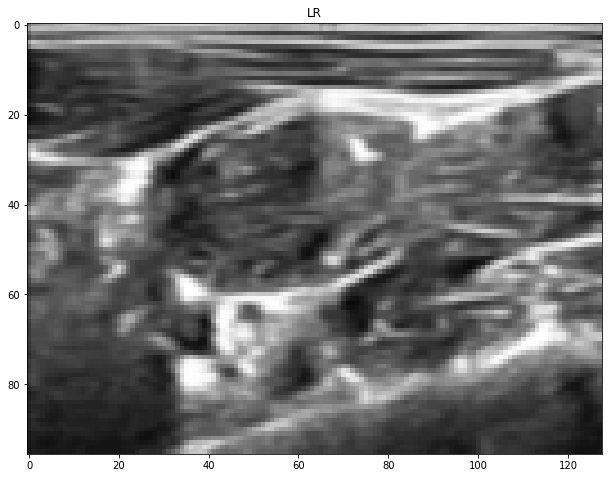

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

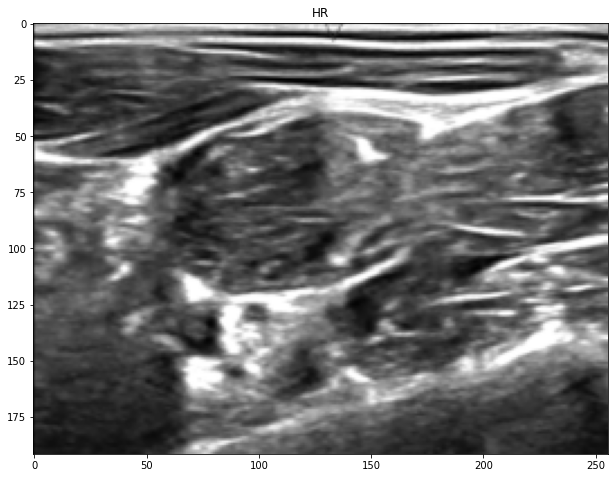

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

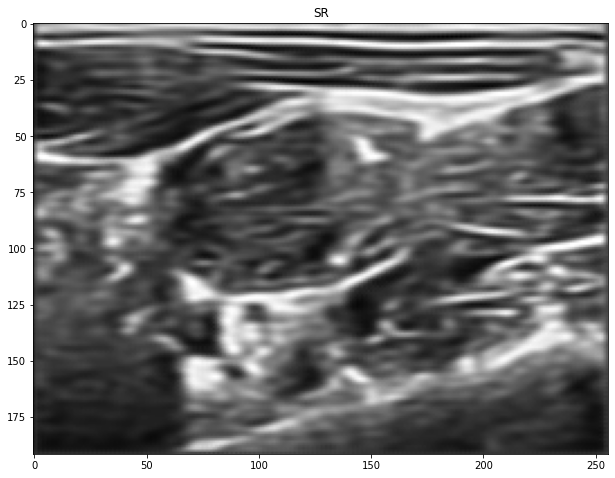

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

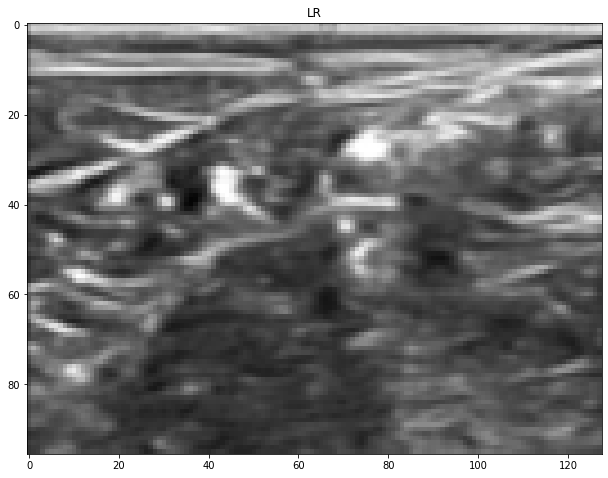

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

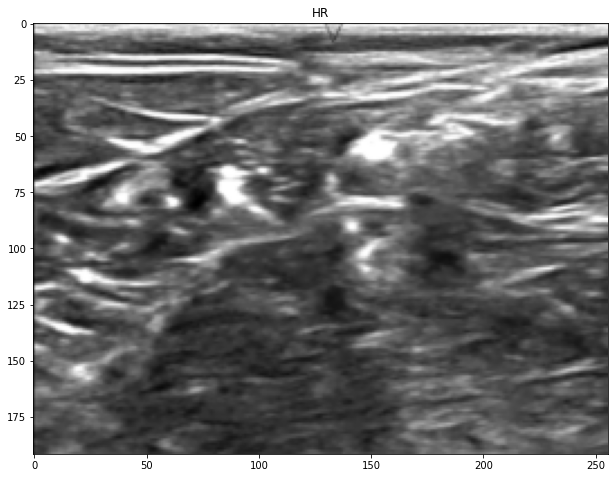

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

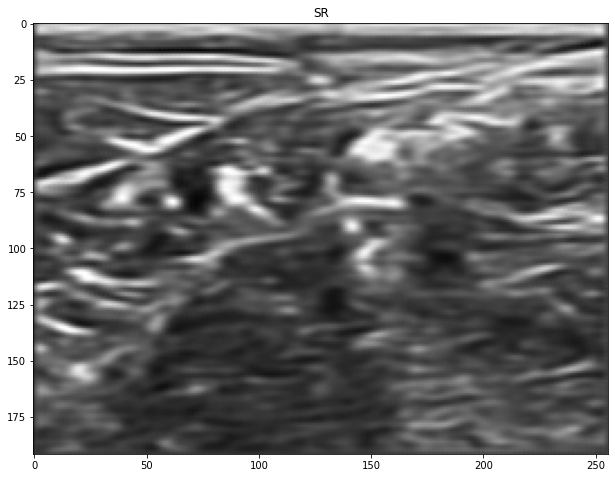

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

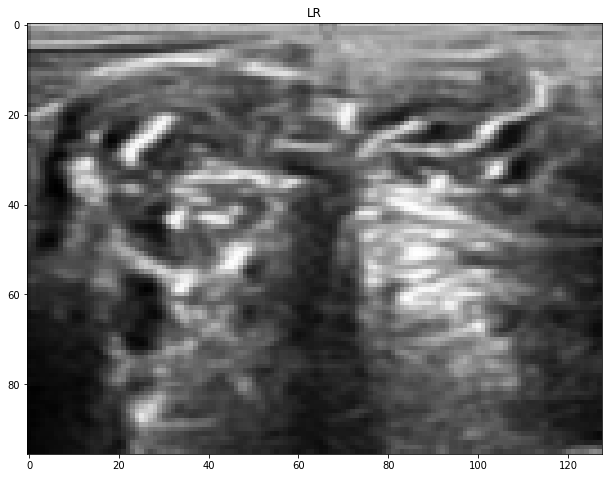

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

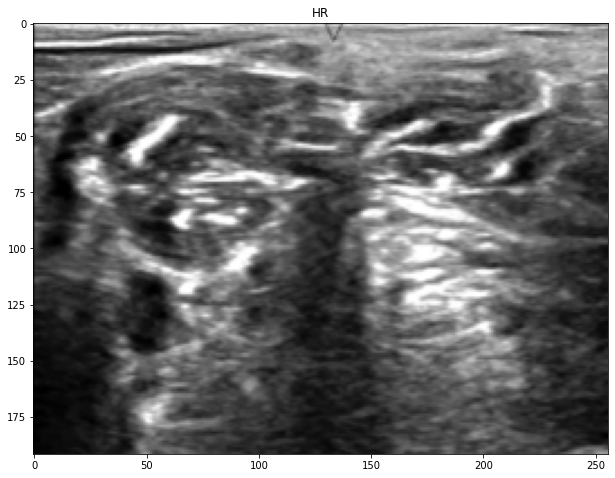

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

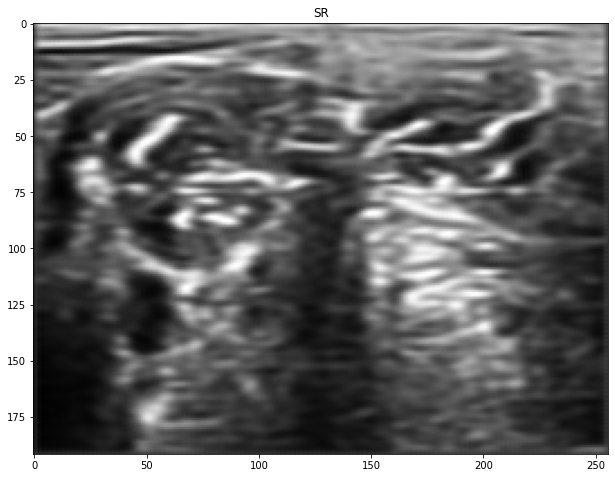

<IPython.core.display.Javascript object>

In [21]:
from google.colab import widgets
import itertools

show_examples(valid_set, model)